# Модель для предсказания оценки шахматной позиции

# Готовим первый датасет с 152.894 партиями между игроками > 2000 ELO

In [1]:
import pandas as pd
import stockfish
import chess, chess.pgn
import io
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics
import numpy as np

In [3]:
# https://www.kaggle.com/datasets/arevel/chess-games?resource=download
df = pd.read_csv("chess_games.csv")

# Исключим все игры в режиме "Пуля"
# Оставим только партии в которых по крайней мере один игрок достиг рейтинга 2000
# Исключим партии с некорректной записью и слишком короткие партии
# Оставим только партии, которые закончились матом

print("Количество партий в датасете до фильтрации:", len(df))

temp_df = df.drop(df[(df['Event'] == ' Bullet tournament ') | (df['Event'] == 'Bullet tournament ') | (df['Event'] == ' Bullet ') | (df['Event'] == 'Bullet ')].index)
filter_df = temp_df.drop(temp_df[(temp_df['WhiteElo'] < 2000) & (temp_df['BlackElo'] < 2000)].index)
second_filter = filter_df.drop(filter_df[(~filter_df['AN'].str.contains('#')) | (filter_df['Result'] == "1/2-1/2")].index)

notation_data = second_filter[['AN']]
notation_data = notation_data[notation_data['AN'].str.len() >= 100]
notation_data = notation_data[~notation_data['AN'].str.contains('{')]
notation_data.reset_index(drop=True, inplace=True)

print("Количество партий в датасете после фильтрации:", len(notation_data))
print(notation_data.head())

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

# Готовим второй датасет с оценкой 12,958,035 fen позиций движком Stockfish на глубине 22

In [122]:
# https://www.kaggle.com/datasets/ronakbadhe/chess-evaluations
fen_data = pd.read_csv("fen_to_stockfish_evaluations.csv")

print(len(fen_data))
print(fen_data.head())

12958035
                                                 FEN Evaluation
0  rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR ...        -10
1  rnbqkbnr/pppp1ppp/4p3/8/4P3/8/PPPP1PPP/RNBQKBN...        +56
2  rnbqkbnr/pppp1ppp/4p3/8/3PP3/8/PPP2PPP/RNBQKBN...         -9
3  rnbqkbnr/ppp2ppp/4p3/3p4/3PP3/8/PPP2PPP/RNBQKB...        +52
4  rnbqkbnr/ppp2ppp/4p3/3p4/3PP3/8/PPPN1PPP/R1BQK...        -26


# Преобразуем первый датасет в формат второго
## Все 6 датасетов - https://clck.ru/35XoUg

In [2]:
# Для этого прогоним все позиции из партий первого датасета через stockfish

# http://web.ist.utl.pt/diogo.ferreira/papers/ferreira13impact.pdf , страница 77
stockfishEngine = stockfish.Stockfish(path="/home/sergey/stockfish/stockfish-ubuntu-x86-64-avx2", depth=8)

def who_move_from_fen(fen):
    res = fen.split(' ')[1]
    if (res == "w"):
        return "-"
    return "+"

fens = []
evaluetes = []

start_time = time.time()

for i, row in notation_data.iterrows():
    # Идём по всем играм
    game = chess.pgn.read_game(io.StringIO(row["AN"]))
    end_game = game.end()
    
    while end_game:
        # Идём по всем доскам в игре
        fen = end_game.board().fen().strip()
        stockfishEngine.set_fen_position(fen)
        ev = stockfishEngine.get_evaluation()
        
        if (ev['type'] == "mate"): # '#-0' - чёрные поставили мат, '#+0' - белые поставили мат
            if (str(ev['value']) == "0"):
                side = who_move_from_fen(fen)
                evaluetes.append("#" + side + str(ev['value']))
            else:
                evaluetes.append("#" + str(ev['value']))
        else:
            evaluetes.append(ev['value'])
            
        
        fens.append(fen)
        end_game = end_game.parent
        
    if ((i + 1) % 1000 == 0):
        print(str(i + 1) + " / 152894")
        print(time.time() - start_time)
        start_time = time.time()
        
        if ((i + 1) % 51000 == 0):
            temp_df = pd.DataFrame({'FEN': fens, 'Evaluation': evaluetes})
            temp_df.to_csv(str(i + 1) + '_temp_fen.csv', encoding='utf-8', index=False)

final_df = pd.DataFrame({'FEN': fens, 'Evaluation': evaluetes})
final_df.to_csv('final_fen.csv', encoding='utf-8', index=False)

NameError: name 'time' is not defined

## Создадим 3 итоговых и 3 временных датасета

In [237]:
def convert_to_fen_without_moves(fen):
    res = fen.strip().split(' ')
    return res[0] + ' ' + res[1]

# Оставим только уникальные FEN записи
unique_fen_data = fen_data.groupby('FEN').first().reset_index()

print(len(unique_fen_data)) # 12954834
print(unique_fen_data.head())

deep22 = unique_fen_data
deep22.to_csv('deep22.csv', encoding='utf-8', index=False)

# Оставим только уникальные FEN записи
deep8 = final_df.groupby('FEN').first().reset_index()

print(len(deep8)) # 10257309
print(deep8.head())

deep8.to_csv('deep8.csv', encoding='utf-8', index=False)

df_append = deep22.append(deep8, ignore_index=True)
df_append.reset_index()

# Оставим только уникальные FEN записи
deep22_merge_deep8 = df_append.groupby('FEN').first().reset_index()

print(deep22_merge_deep8)
print(len(deep22_merge_deep8)) # 23167005

deep22_merge_deep8.to_csv('deep22_merge_deep8.csv', encoding='utf-8', index=False)

# Преобразуем FEN записи в укороченный формат, вида - '8/8/8/8 w'
deep22['FEN'] = deep22['FEN'].apply(convert_to_fen_without_moves)
deep8['FEN'] = deep8['FEN'].apply(convert_to_fen_without_moves)

# Оставим только уникальные укороченные FEN записи
deep22 = deep22.groupby('FEN').first().reset_index()
deep8 = deep8.groupby('FEN').first().reset_index()

df_append = deep22.append(deep8, ignore_index=True)
# Оставим только уникальные укороченные FEN записи
deep22_merge_deep8 = df_append.groupby('FEN').first().reset_index()

print(len(deep22)) # 12953389
print(len(deep8)) # 10129813
print(len(deep22_merge_deep8)) # 23023152

deep22.to_csv('deep22_with_trim_fen.csv', encoding='utf-8', index=False)
deep8.to_csv('deep8_with_trim_fen.csv', encoding='utf-8', index=False)
deep22_merge_deep8.to_csv('deep22_merge_deep8_with_trim_fen.csv', encoding='utf-8', index=False)

12954834
                                                 FEN Evaluation
0        1B1K2k1/1R4p1/5p2/8/r7/6P1/8/8 w - - 87 100        +68
1          1B1K4/1R3kp1/5p2/8/r7/6P1/8/8 b - - 86 99        +66
2    1B1N2k1/6n1/2p2p1p/3p2p1/3P4/7P/7K/8 w - - 2 46        +87
3     1B1Nn1k1/8/2p2p1p/3p2p1/3P4/7P/7K/8 b - - 1 45       +102
4  1B1Q1bk1/6pp/p1q2p2/1p2p3/2r5/2n2PP1/P3R1KP/3R...          0
10257309
                                               FEN Evaluation
0  1B1K4/1p3k2/2p1b1p1/1r3P2/8/5R1p/8/8 b - - 0 45       -553
1  1B1K4/1p3k2/2p1b1p1/1r5p/5P2/4R3/8/8 b - - 1 43       -452
2  1B1K4/1p3k2/2p1b1p1/1r6/5P1p/4R3/8/8 w - - 0 44       -459
3  1B1K4/1p3k2/2p1b1p1/1r6/5P1p/5R2/8/8 b - - 1 44       -509
4  1B1K4/1p3k2/2p1b1p1/1r6/5P2/5R1p/8/8 w - - 0 45       -472


/tmp/ipykernel_9417/3260246767.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_append = deep22.append(deep8, ignore_index=True)


                                                        FEN Evaluation
0               1B1K2k1/1R4p1/5p2/8/r7/6P1/8/8 w - - 87 100        +68
1                 1B1K4/1R3kp1/5p2/8/r7/6P1/8/8 b - - 86 99        +66
2           1B1K4/1p3k2/2p1b1p1/1r3P2/8/5R1p/8/8 b - - 0 45       -553
3           1B1K4/1p3k2/2p1b1p1/1r5p/5P2/4R3/8/8 b - - 1 43       -452
4           1B1K4/1p3k2/2p1b1p1/1r6/5P1p/4R3/8/8 w - - 0 44       -459
...                                                     ...        ...
23167000  rrqn2k1/3bbp1p/3p4/3Pp1p1/pPN1Pn2/N3B2P/2BQ1PP...       +406
23167001  rrqn2k1/3bbp1p/3p4/3Pp1p1/pPN1Pn2/N3B2P/3Q1PP1...       +385
23167002  rrqn2k1/4pp1p/3p2p1/2pQ4/P3P2P/1PB3P1/5P2/1R1R...        +27
23167003  rrqn2k1/4pp1p/3p2p1/2pQ4/P6P/1PB3P1/4PP2/1R1R2...        +61
23167004  rrqnn1k1/p2b1pbp/Q2p2p1/B1pPp3/2P5/1R3NP1/P2NP...       +141

[23167005 rows x 2 columns]
23167005


/tmp/ipykernel_9417/3260246767.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_append = deep22.append(deep8, ignore_index=True)


12953389
10129813
23023152


# Преобразуем итоговые датасеты для передачи их в нейросеть

<img src="https://i.ibb.co/PcVVy7W/Grm-U05-2-GKQ.jpg" alt="Grm-U05-2-GKQ" border="0">

In [51]:
def fen_to_bitmap_and_who_move_data(board):
    # Функция переводит fen запись в понятную для нейросети форму
    # Фигура помечается знаком 0, когда ее нет на этом поле, знаком 1, когда она принадлежит игроку, 
    # который должен сделать ход, и знаком −1, когда она принадлежит противнику.

    bitmap = []
    colors = [board.turn, not board.turn]
    pieces = [chess.PAWN, chess.KNIGHT, chess.BISHOP, chess.ROOK, chess.QUEEN, chess.KING]

    for color in colors:
        for piece in pieces:
            squares = board.pieces(piece, color)
            bitmap_ = [0] * 64

            for square in squares:
                if (color == board.turn):
                    bitmap_[square] = 1
                else:
                    bitmap_[square] = -1

            bitmap.append(bitmap_) # ex
    
    return bitmap

def get_value_from_mate_value(mate_value):
    abs_max_value = 15319
    d_centipawn = 10
    
    res = ((25 - int(mate_value[2:])) * d_centipawn) + abs_max_value
    
    if (mate_value[1] == '-'):
        return res * -1
    return res

def get_value_from_mate_value_2(mate_value):
    abs_max_value = 15319
    d_centipawn = 10
    
    int_val = abs(int(mate_value[1:]))
    
    res = ((25 - int_val) * d_centipawn) + abs_max_value
    
    if (mate_value[1] == '-'):
        return res * -1
    return res

def stockfish_value_to_number_value(value, side):
    #if value[0] == '+':
    #    return int(value[1:])
    if value[0] == '-' or value[0] == '0':
        return int(value) * side
    if value[0] == '#':
        return get_value_from_mate_value_2(value) * side
    return int(value) * side # del
    raise Exception("Dont know start char for value - " + value)
    
def get_values_from_df(df):
    X = []
    y = []
    
    for index, row in df.iterrows():
        side = -1 # -1 если ход чёрных, иначе 1
        board = chess.Board()
        board.set_fen(row['FEN'])
        
        if board.turn == 1:
            side = 1
    
        X.append(fen_to_bitmap_and_who_move_data(board))
        y.append(stockfish_value_to_number_value(row['Evaluation'], side))
        if (index % 100000 == 0 and index != 0):
            print(index)
        if ((index + 1) % 700000 == 0): # Слишком много данных
            break
    
    return X, y

<img src="https://i.ibb.co/CsYYfs8/cw-Fmakm-CUs-E.jpg" alt="cw-Fmakm-CUs-E" border="0">

# Обучим модель

In [52]:
import sklearn
import numpy as np

df = pd.read_csv("deep8_with_trim_fen.csv")

In [53]:
import numpy as np

def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

X, y = get_values_from_df(df)
y  = NormalizeData(y).tolist()

100000
200000
300000
400000
500000
600000


In [54]:
# https://www.researchgate.net/publication/322539902_Learning_to_Evaluate_Chess_Positions_with_Deep_Neural_Networks_and_Limited_Lookahead

from keras.models import Sequential
from keras.layers import Dense, Flatten, BatchNormalization
import keras

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

model = Sequential()
model.add(Flatten(input_shape=(12,64)))
 
model.add(Dense(2048, activation='elu'))
model.add(BatchNormalization())

model.add(Dense(2048, activation='elu'))
model.add(BatchNormalization())

model.add(Dense(2048, activation='elu'))

model.add(Dense(1, activation='linear'))

model.summary()

sgd = keras.optimizers.legacy.SGD(learning_rate=0.001, decay=1e-8, momentum=0.7, nesterov=True)
model.compile(loss='mean_squared_error', optimizer=sgd)

history = model.fit(X_train, y_train, batch_size=256, epochs=50)
tests = model.evaluate(np.array(X_test), np.array(y_test), batch_size=256)

model.save('700k.h5')

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 768)               0         
                                                                 
 dense_12 (Dense)            (None, 2048)              1574912   
                                                                 
 batch_normalization_6 (Bat  (None, 2048)              8192      
 chNormalization)                                                
                                                                 
 dense_13 (Dense)            (None, 2048)              4196352   
                                                                 
 batch_normalization_7 (Bat  (None, 2048)              8192      
 chNormalization)                                                
                                                                 
 dense_14 (Dense)            (None, 2048)             

2023-09-02 15:04:33.210042: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3870720000 exceeds 10% of free system memory.


2461/2461 [==============================] - 140s 57ms/step - loss: 0.0557
Epoch 2/50
2461/2461 [==============================] - 138s 56ms/step - loss: 0.0238
Epoch 3/50
2461/2461 [==============================] - 136s 55ms/step - loss: 0.0187
Epoch 4/50
2461/2461 [==============================] - 136s 55ms/step - loss: 0.0166
Epoch 5/50
2461/2461 [==============================] - 138s 56ms/step - loss: 0.0155
Epoch 6/50
2461/2461 [==============================] - 138s 56ms/step - loss: 0.0149
Epoch 7/50
2461/2461 [==============================] - 136s 55ms/step - loss: 0.0145
Epoch 8/50
2461/2461 [==============================] - 138s 56ms/step - loss: 0.0142
Epoch 9/50
2461/2461 [==============================] - 140s 57ms/step - loss: 0.0141
Epoch 10/50
2461/2461 [==============================] - 135s 55ms/step - loss: 0.0139
Epoch 11/50
2461/2461 [==============================] - 135s 55ms/step - loss: 0.0138
Epoch 12/50
2461/2461 [==============================] - 135s 5

/home/sergey/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


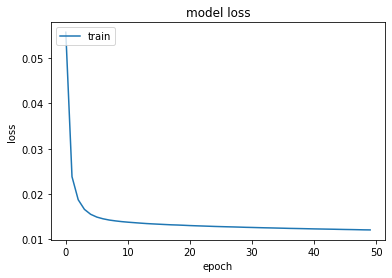

0.01260080374777317


In [55]:
from matplotlib import pyplot as plt

plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

print(tests)

In [56]:
from keras.models import load_model
model = load_model('700k.h5')

In [76]:
def simple_negamax(board, is_max):
    max_min = 1
    if is_max:
        max_min = 0
        
    res_move = 0
    
    if (depth == 0):
        
    
    for move in board.legal_moves:
        board.push(move)
        
        if is_max:
            bitmap = fen_to_bitmap_and_who_move_data(board)
            pred = model.predict([bitmap])[0][0]
        
            if pred > max_min:
                max_min = pred
                res_move = move
        else:
            if pred < max_min:
                max_min = pred
                res_move = move
        
        board.pop()
    
    return res_move.uci()

def get_best_move_by_fen(fen):
    board = chess.Board()
    board.set_fen(fen)
    
    return simple_negamax(board, True)


get_best_move_by_fen("rnb1kbnr/pppppppp/1q6/8/8/8/3PPP2/1Q2K3 b kq - 0 1")

1/1 [==============================] - 0s 23ms/step
0.6187944
h5h7
1/1 [==============================] - 0s 22ms/step
0.57233953
h5f7
1/1 [==============================] - 0s 24ms/step
0.5734871
h5h6
1/1 [==============================] - 0s 24ms/step
0.5825079
h5g6
1/1 [==============================] - 0s 23ms/step
0.54495645
h5g5
1/1 [==============================] - 0s 23ms/step
0.5294912
h5f5
1/1 [==============================] - 0s 23ms/step
0.5565126
h5e5
1/1 [==============================] - 0s 24ms/step
0.55114406
h5h4
1/1 [==============================] - 0s 23ms/step
0.5452558
h5g4
1/1 [==============================] - 0s 22ms/step
0.5591615
h5h3
1/1 [==============================] - 0s 22ms/step
0.5465896
h5f3
1/1 [==============================] - 0s 23ms/step
0.5569944
h5e2
1/1 [==============================] - 0s 23ms/step
0.52337176
h5d1
1/1 [==============================] - 0s 23ms/step
0.5802749
c3d5
1/1 [==============================] - 0s 24ms/step
0.5647

'h5h7'